In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D,
                                     LayerNormalization, MaxPooling2D, MultiHeadAttention, Add,
                                     Activation)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from PIL import Image
import datetime
from sklearn.linear_model import LogisticRegression

# --- Paths và tham số ---
root_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed/"
paths = [
    os.path.join(root_dir, "im_Dyskeratotic", "im_Dyskeratotic", "CROPPED"),
    os.path.join(root_dir, "im_Koilocytotic", "im_Koilocytotic", "CROPPED"),
    os.path.join(root_dir, "im_Metaplastic", "im_Metaplastic", "CROPPED"),
    os.path.join(root_dir, "im_Parabasal", "im_Parabasal", "CROPPED"),
    os.path.join(root_dir, "im_Superficial-Intermediate", "im_Superficial-Intermediate", "CROPPED")
]

height, width, channels = 64, 64, 3
num_classes = len(paths)

# --- Load images function ---
def load_images_from_paths(paths, img_size=(height, width)):
    images = []
    labels = []
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
    for idx, p in enumerate(paths):
        if not os.path.exists(p):
            print(f"Warning: path not found {p}")
            continue
        for file in os.listdir(p):
            if not file.lower().endswith(valid_extensions):
                continue
            try:
                img_path = os.path.join(p, file)
                img = Image.open(img_path).convert('RGB').resize(img_size)
                img = np.array(img).astype(np.float32) / 255.0
                if img.shape != (height, width, channels):
                    continue
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Failed loading {file}: {e}")
                continue
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

print("Loading images...")
data, labels = load_images_from_paths(paths)
print(f"Loaded {data.shape[0]} images.")

labels_one_hot = tf.one_hot(labels, depth=num_classes).numpy()

# --- Train-validation-test split ---
X_train, X_tmp, y_train, y_tmp = train_test_split(
    data, labels_one_hot, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=np.argmax(y_tmp, axis=1))

# --- Data augmentation ---
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# --- BoTNet Bottleneck block với MHSA ---
def botnet_block(inputs, filters, num_heads, key_dim, dropout_rate=0.1):
    x = Conv2D(filters // 4, kernel_size=1, padding='same', activation='relu')(inputs)
    h, w, c = x.shape[1], x.shape[2], x.shape[3]
    x_reshaped = tf.reshape(x, (-1, h * w, c))  # (batch, seq_len, channels)
    x_norm = LayerNormalization(epsilon=1e-6)(x_reshaped)
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x_norm, x_norm)
    attn_out = Dropout(dropout_rate)(attn_out)
    x = Add()([x_reshaped, attn_out])
    x = LayerNormalization(epsilon=1e-6)(x)
    ffn = Dense(filters // 4 * 4, activation='relu')(x)
    ffn = Dense(filters // 4)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    x = Add()([x, ffn])
    x = tf.reshape(x, (-1, h, w, filters // 4))
    x = Conv2D(filters, kernel_size=1, padding='same')(x)
    x = Add()([inputs, x])
    x = Activation('relu')(x)
    return x

# --- Model BoTNet ---
def create_botnet_model(input_shape=(height, width, channels), num_classes=num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x = botnet_block(x, filters=128, num_heads=4, key_dim=32, dropout_rate=0.1)
    x = MaxPooling2D()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_botnet_model()
model.summary()

# --- Callbacks ---
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_botnet_model.keras", monitor="val_accuracy", save_best_only=True, mode="max")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# --- Huấn luyện BoTNet ---
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard_cb]
)

# --- Load weights tốt nhất ---
model.load_weights("best_botnet_model.keras")

# --- Đánh giá trên tập test bằng BoTNet ---
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)
y_test_int = np.argmax(y_test, axis=1)

# --- Trích xuất đặc trưng từ BoTNet để train SVM ---
def extract_features(model, data):
    # Lấy output của layer trước dense cuối (GlobalAveragePooling2D output)
    feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
    features = feature_extractor.predict(data)
    return features

X_train_features = extract_features(model, X_train)
X_val_features = extract_features(model, X_val)
X_test_features = extract_features(model, X_test)

# Flatten đặc trưng cho SVM
X_train_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_val_flat = X_val_features.reshape(X_val_features.shape[0], -1)
X_test_flat = X_test_features.reshape(X_test_features.shape[0], -1)

# Chuẩn hóa đặc trưng trước khi train SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Chuyển nhãn one-hot về dạng int cho SVM
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)
y_test_int = np.argmax(y_test, axis=1)


# --- Train Logistic Regression ---
print("Training Logistic Regression...")
log_reg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000
)
log_reg.fit(X_train_scaled, y_train_int)

# --- Đánh giá Logistic Regression ---
y_val_pred = log_reg.predict(X_val_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

print("=== Logistic Regression Classifier ===")
print("Validation Accuracy:", accuracy_score(y_val_int, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test_int, y_test_pred))
print("Classification Report on Test Set:\n", classification_report(y_test_int, y_test_pred))


Loading images...
Loaded 4049 images.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 64)   0           conv2d_1[0][0]                   
________________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/100
45/45 [==============================] - 20s 211ms/step - loss: 1.2890 - accuracy: 0.4333 - val_loss: 1.1656 - val_accuracy: 0.4498
Epoch 2/100
45/45 [==============================] - 8s 169ms/step - loss: 1.0940 - accuracy: 0.5508 - val_loss: 0.9540 - val_accuracy: 0.6161
Epoch 3/100
45/45 [==============================] - 8s 172ms/step - loss: 1.0223 - accuracy: 0.5992 - val_loss: 0.8956 - val_accuracy: 0.6573
Epoch 4/100
45/45 [==============================] - 8s 174ms/step - loss: 0.9260 - accuracy: 0.6443 - val_loss: 0.8150 - val_accuracy: 0.6787
Epoch 5/100
45/45 [==============================] - 8s 173ms/step - loss: 0.9107 - accuracy: 0.6429 - val_loss: 0.7862 - val_accuracy: 0.6969
Epoch 6/100
45/45 [==============================] - 8s 174ms/step - loss: 0.7625 - accuracy: 0.7205 - val_loss: 0.6347 - val_accuracy: 0.7809
Epoch 7/100
45/45 [==============================] - 8s 174ms/step - loss: 0.6749 - accuracy: 0.7551 - val_loss: 0.5548 - val_accuracy: 0.795

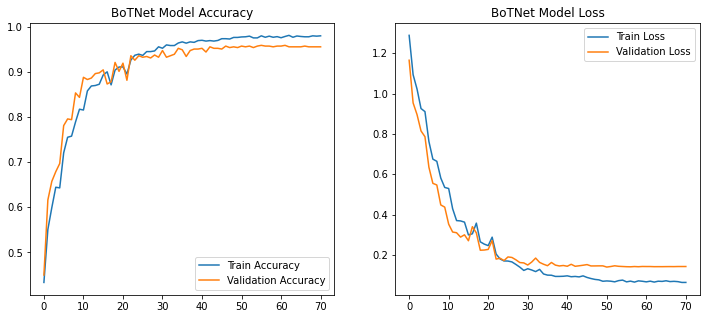

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Visualize Training History của BoTNet ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('BoTNet Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('BoTNet Model Loss')

plt.show()

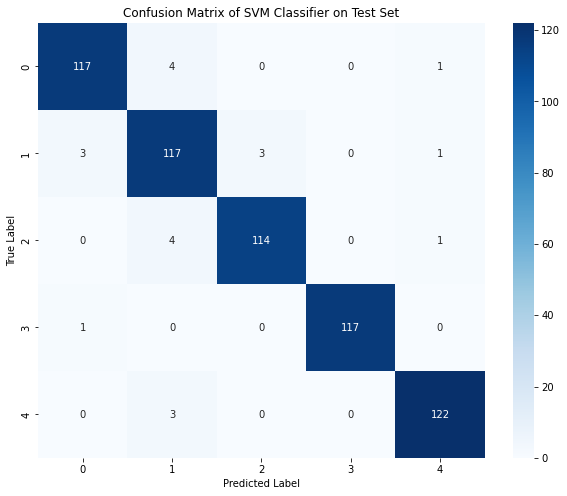

In [4]:
# --- Ma trận nhầm lẫn cho SVM trên tập test ---
cm = confusion_matrix(y_test_int, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes),
            yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of SVM Classifier on Test Set')
plt.show()


10 test predictions vs actual labels:
Prediction: 3, Actual: 3
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 3, Actual: 3
Prediction: 3, Actual: 3
Prediction: 2, Actual: 2
Prediction: 0, Actual: 0
Prediction: 4, Actual: 4
Prediction: 4, Actual: 4
Prediction: 0, Actual: 0


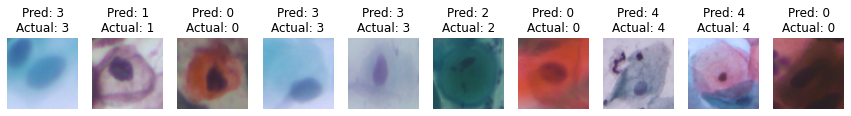

In [6]:
# --- In ra 10 giá trị dự đoán và thực tế từ tập test ---
print("10 test predictions vs actual labels:")
for i in range(10):
    print(f"Prediction: {y_test_pred[i]}, Actual: {y_test_int[i]}")


# --- Hiển thị ảnh cùng dự đoán và nhãn thực tế ---
def display_images_with_predictions(X_test, y_pred, y_true, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        # X_test[i] đã chuẩn hóa [0,1], có thể hiển thị trực tiếp
        plt.imshow(X_test[i])
        plt.title(f"Pred: {y_pred[i]}\nActual: {y_true[i]}")
        plt.axis("off")
    plt.show()

display_images_with_predictions(X_test, y_test_pred, y_test_int, num_images=10)

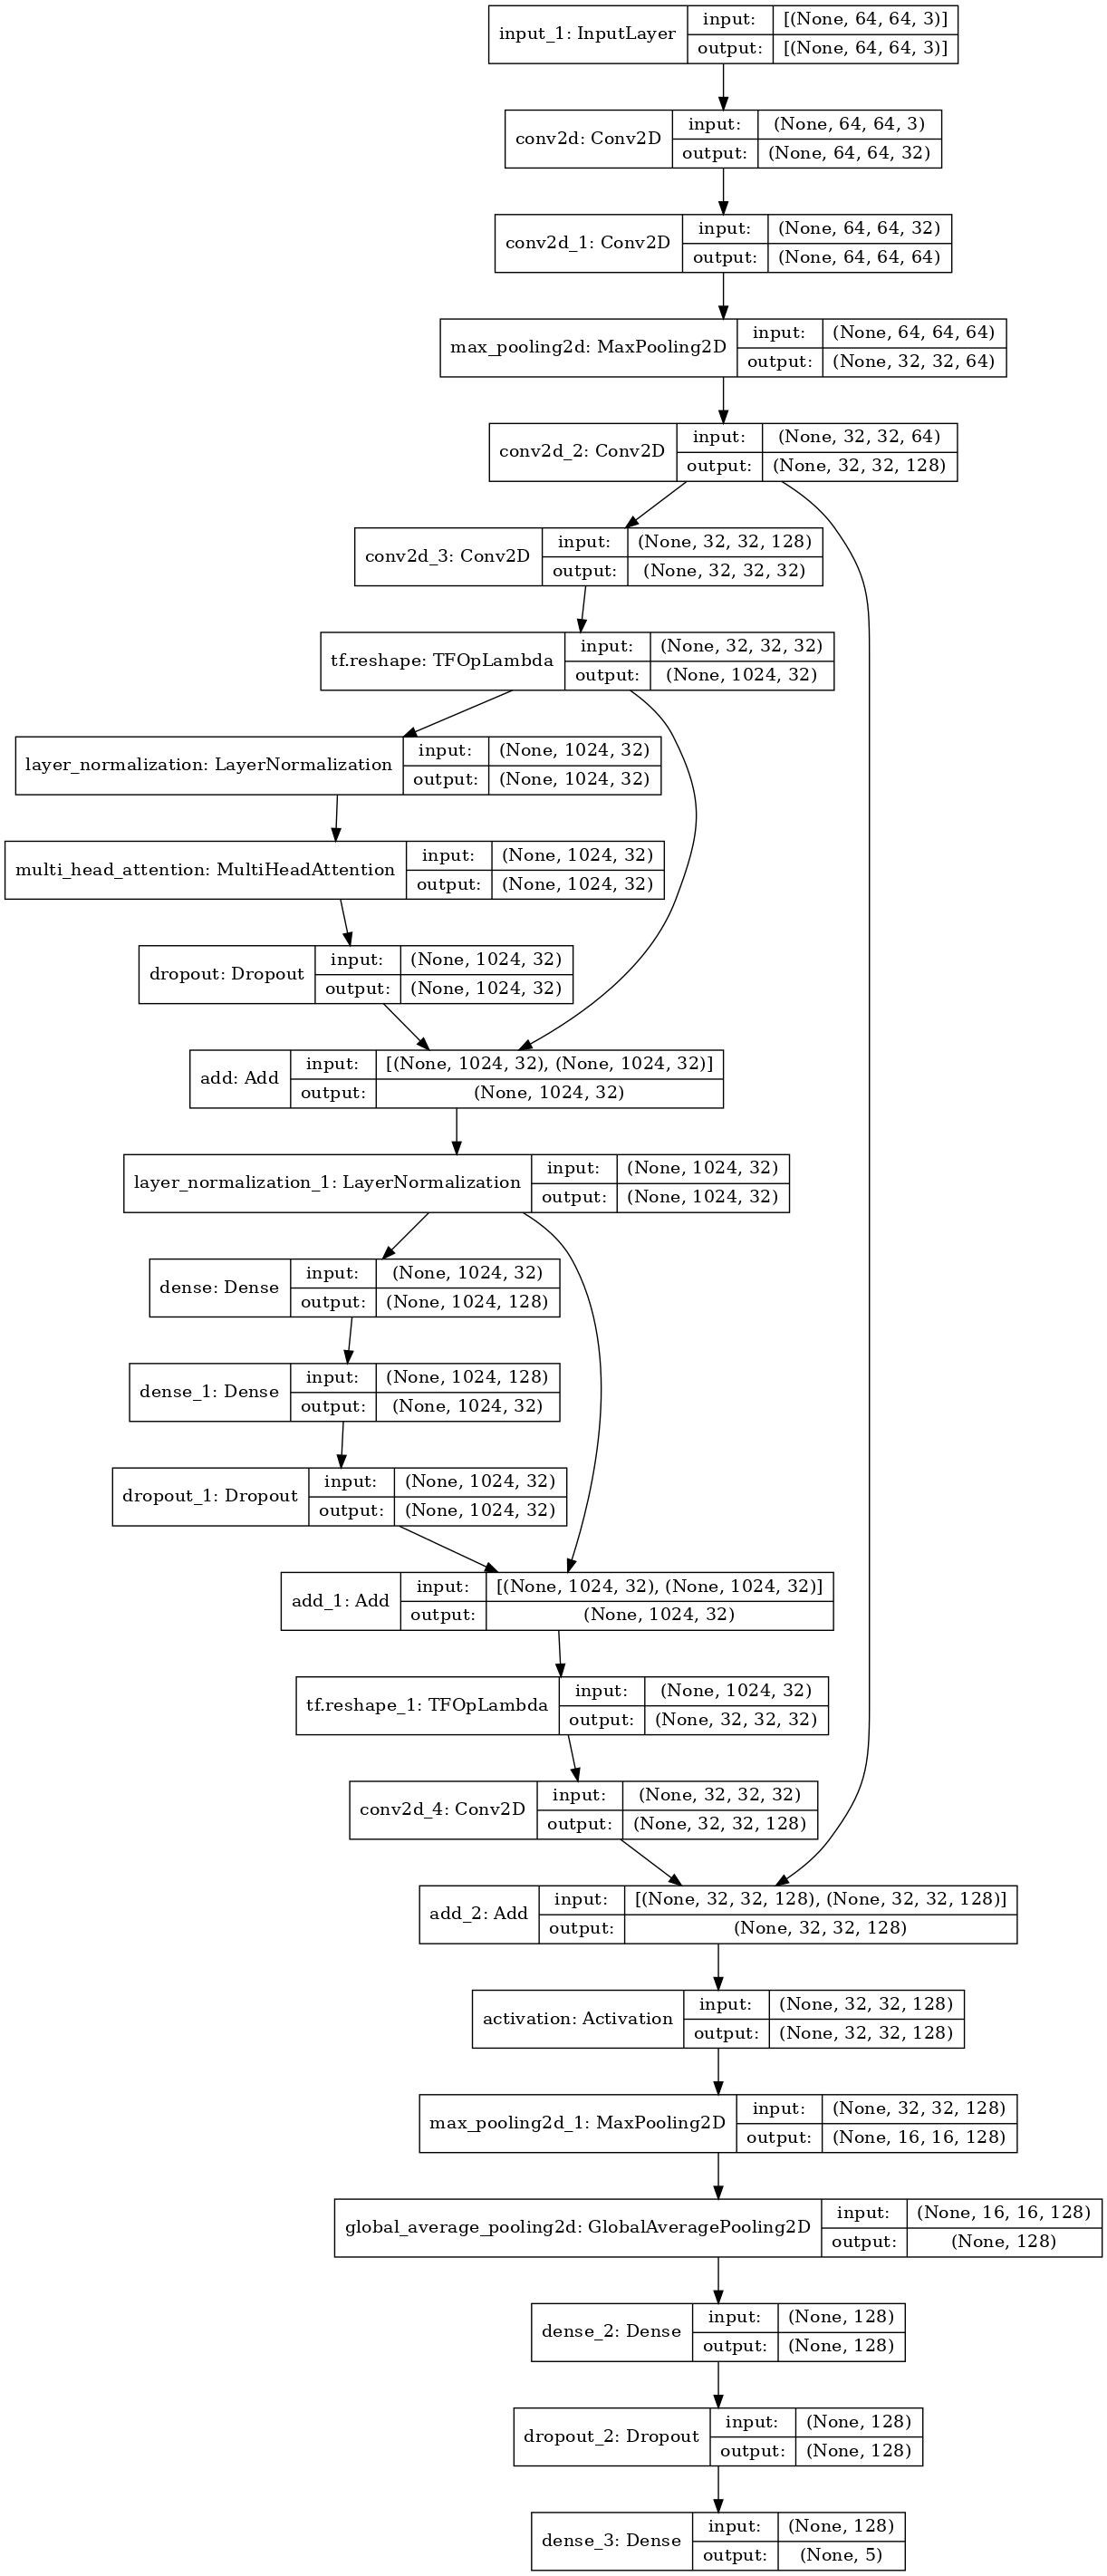

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=False, dpi=100)